### 할당된 GPU 확인

In [1]:
!nvidia-smi

Tue Jun 15 03:48:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Drive mount

In [2]:
from google.colab import drive
import os, sys

drive.mount('/content/drive')

Mounted at /content/drive


### 필요한 library 및 자료 다운로드

In [3]:
!pip install  mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

     |████████████████████████████████| 46.9MB 110kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 15.4MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595707 sha256=40a3b4ae4bc6bbd66e283f09d358ac2f5c42dd91489db74e450cba3404ecaa45
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.2MB 15.4MB/s 
     |████████████████████████████████| 2.3MB 15.1MB/s 
     |████████████████████████████████| 901kB 42.4MB/s 
     |████████████████████████████████| 3.3MB 49.3MB/s 


In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [5]:
from transformers import AdamW, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup

### gpu 사용

In [6]:
##GPU 사용 시
device = torch.device("cuda:0")

### Pretrained bert, vocab load

In [7]:
#bertmodel, vocab = get_pytorch_kobert_model()
#bertmodel = get_kobert_model()

model_path = '/content/drive/MyDrive/kobert_from_pretrained'
vocab_file = '/content/drive/MyDrive/kobert_news_wiki_ko_cased-1087f8699e.spiece'
bertmodel = BertModel.from_pretrained(model_path)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file, padding_token='[PAD]')

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

### 우리가 사용하는 dataset 가져와서 train, validation, test set으로 분류

In [9]:
file1 = '/content/drive/MyDrive/problem_ner_multilabel_re_addonlykorean_replacevariable_replacenumber.csv'
file3 = '/content/drive/MyDrive/ner_preprocessed_complete_re_drop_addonlykorean_replacevariable_replacenumber_8_label_single.csv'

In [10]:
df = pd.read_csv(file3)

### tag가 string이기 때문에 숫자로 바꾸기 위해서 encoder라는 것을 사용한다
### encoder를 사용하면 쉽게 tag의 문자를 숫자로 바꿔준다

In [11]:
#라벨의 숫자화
label = df['tag'].values
encoder = LabelEncoder()
encoder.fit(label)

LabelEncoder()

### label별 data 개수가 불균형한 경우 학습에 영향을 주기 때문에 loss 가중치를 조정하여 해결할 수도 있다
### 우리 학습할 땐 사용 안했음

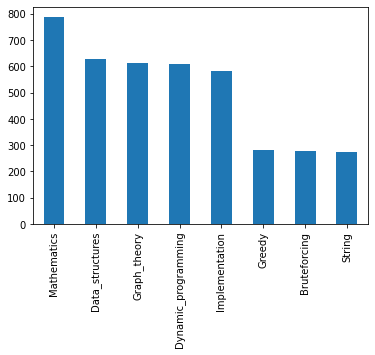

['Bruteforcing' 'Data_structures' 'Dynamic_programming' 'Graph_theory'
 'Greedy' 'Implementation' 'Mathematics' 'String']
tensor([1.8255, 0.8068, 0.8333, 0.8279, 1.7933, 0.8690, 0.6440, 1.8388])


In [12]:
df.tag.value_counts().plot(kind='bar')
plt.show()

class_loss = [df.tag.value_counts()[i] for i in encoder.classes_ ]
class_weights = compute_class_weight('balanced', np.unique(df['tag']), df['tag'])
weights= torch.tensor(class_weights,dtype=torch.float)
print(encoder.classes_)
print(weights)

In [13]:
### 분류한 dataset을 형식에 맞게 변환하는 코드

In [14]:
def set_data(dataframe) :
  dataset = []
  tmp = encoder.transform(dataframe['tag'])
  i = 0
  for index, row in dataframe.iterrows():
   problem = row['desc_variabel_renumber_0']
   if not pd.isna(row['input_variabel_renumber_0']) :
      problem = problem + row['input_variabel_renumber_0']

   dataset.append([problem , tmp[i]])
   i = i + 1
  return dataset

In [15]:
dataset = set_data(df)

### tokenizer는 문장을 단어로 나눠주는 역할을 한다

In [16]:
#tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(vocab_file, vocab, lower=False)

### 데이터셋 관련 코드

In [17]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


### model parameter


In [18]:
## Setting parameters
max_len = 512
batch_size = 32

### 데이터 셋 표준화 과정

In [19]:
data_all = BERTDataset(dataset, 0, 1, tok, max_len, True, False)

In [20]:
dataloader = torch.utils.data.DataLoader(data_all, batch_size=batch_size, num_workers=4)

### 우리가 사용할 모델 정의 
### bert 모델 뒤에 single layer 추가해서 softmax로 분류하는 방식

In [21]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
   
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        op, _ = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)
        x = op[:,:16, :]
        y = op[:,-48:, :]
        output = torch.cat((x,y), dim = 1)

        return output

### model 할당

In [22]:
model = BERTClassifier(bertmodel, num_classes=8, dr_rate=0.0).to(device) 

In [23]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [24]:
output = []

with torch.no_grad():
  model.eval()
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    output.extend(out.to('cpu').tolist())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [25]:
df['vector'] = output

In [26]:
train_df, remaining = train_test_split(df, random_state = 46, train_size = 0.7, stratify = df.tag.values)
valid_df, test_df = train_test_split(remaining, random_state=46, train_size = 0.5, stratify = remaining.tag.values)

In [27]:
def set_data_vector(dataframe) :
  dataset = []
  tmp = encoder.transform(dataframe['tag'])
  i = 0
  for index, row in dataframe.iterrows():
   dataset.append([torch.tensor(row['vector']) , tmp[i]])
   i = i + 1
  return dataset

In [28]:
data_train = set_data_vector(train_df)
data_valid = set_data_vector(valid_df)
data_test = set_data_vector(test_df)

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=4)

### LSTM define


In [29]:
class Classifier(nn.Module):
    def __init__(self,
                 hidden_size = 768,
                 num_classes=2,
                 layers = 2,
                 dr_rate=0.0,
                 params=None):
       super(Classifier, self).__init__()
       self.hidden_dim = 384
       self.dr_rate = dr_rate
       self.classifier = nn.Linear(self.hidden_dim, num_classes)
       if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
       self.lstm = nn.LSTM(
          input_size = hidden_size,
          hidden_size= self.hidden_dim,
          num_layers = layers, 
          dropout = dr_rate,
          batch_first = True,
          bidirectional=True
       )
    def forward(self, x) :
        _, (out, _) = self.lstm(x)
        out = out[-1]
        if self.dr_rate:
            out = self.dropout(out)
        return self.classifier(out)

In [30]:
net = Classifier(num_classes=8, dr_rate = 0.1).to(device) 

In [31]:
warmup_ratio = 0.1
num_epochs = 40
max_grad_norm = 1
log_interval = 100
learning_rate =  1e-4 #5e-5

In [32]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in net.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01}, #0.01
    {'params': [p for n, p in net.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0} #0.0
]

In [33]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [34]:
t_total = len(dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [35]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [36]:
train_loss_values = []
validation_loss_values = [] 
train_acc_list = []
validation_acc_list = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    validation_loss = 0.0

    net.train()
    for batch_id, (vector, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        vector = vector.to(device)
        label = label.long().to(device)
        out = net.forward(vector)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_loss += loss.item()
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(train_loss)
    train_acc_list.append(train_acc / len(train_dataloader))

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    net.eval()
    for batch_id, (vector, label) in enumerate(tqdm_notebook(valid_dataloader)):
        vector = vector.float().to(device)
        label = label.long().to(device)
        out = net(vector)
        loss = loss_fn(out, label)
        
        validation_loss += loss.item() 
        test_acc += calc_accuracy(out, label)
    print("epoch {} validation acc {}".format(e+1, test_acc / (batch_id+1)))
    validation_loss = validation_loss / len(valid_dataloader)
    validation_loss_values.append(validation_loss)
    validation_acc_list.append(test_acc / len(valid_dataloader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


epoch 1 batch id 1 loss 2.0919432640075684 train acc 0.0625

epoch 1 train acc 0.11311581676750215


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 validation acc 0.1859375


epoch 2 batch id 1 loss 2.048527717590332 train acc 0.28125

epoch 2 train acc 0.19703435609334488



epoch 2 validation acc 0.19375


epoch 3 batch id 1 loss 1.9532978534698486 train acc 0.3125

epoch 3 train acc 0.23871002592912705



epoch 3 validation acc 0.2578125


epoch 4 batch id 1 loss 1.8201582431793213 train acc 0.5

epoch 4 train acc 0.2906763180639585



epoch 4 validation acc 0.28125


epoch 5 batch id 1 loss 1.6724401712417603 train acc 0.4375

epoch 5 train acc 0.3332433016421781



epoch 5 validation acc 0.359375


epoch 6 batch id 1 loss 1.5644053220748901 train acc 0.375

epoch 6 train acc 0.367302290406223



epoch 6 validation acc 0.378125


epoch 7 batch id 1 loss 1.4821752309799194 train acc 0.46875

epoch 7 train acc 0.4085458081244598



epoch 7 validation acc 0.38125


epoch 8 batch id 1 loss 1.3981802463531494 train acc 0.5

epoch 8 train acc 0.4452247191011236



epoch 8 validation acc 0.3828125


epoch 9 batch id 1 loss 1.354654312133789 train acc 0.5

epoch 9 train acc 0.4748001296456353



epoch 9 validation acc 0.3859375


epoch 10 batch id 1 loss 1.2839374542236328 train acc 0.5625

epoch 10 train acc 0.4986765341400173



epoch 10 validation acc 0.3765625


epoch 11 batch id 1 loss 1.3355363607406616 train acc 0.53125

epoch 11 train acc 0.5279008210890234



epoch 11 validation acc 0.3703125


epoch 12 batch id 1 loss 1.1637436151504517 train acc 0.625

epoch 12 train acc 0.560474286949006



epoch 12 validation acc 0.38125


epoch 13 batch id 1 loss 1.1322451829910278 train acc 0.625

epoch 13 train acc 0.597666378565255



epoch 13 validation acc 0.3734375


epoch 14 batch id 1 loss 1.1322293281555176 train acc 0.65625

epoch 14 train acc 0.6042566983578219



epoch 14 validation acc 0.3796875


epoch 15 batch id 1 loss 0.9812866449356079 train acc 0.65625

epoch 15 train acc 0.6163569576490925



epoch 15 validation acc 0.3578125


epoch 16 batch id 1 loss 0.930391788482666 train acc 0.71875

epoch 16 train acc 0.6374243733794296



epoch 16 validation acc 0.3796875


epoch 17 batch id 1 loss 0.9142419695854187 train acc 0.71875

epoch 17 train acc 0.6398822385479689



epoch 17 validation acc 0.3984375


epoch 18 batch id 1 loss 0.924338161945343 train acc 0.6875

epoch 18 train acc 0.6969533275713051



epoch 18 validation acc 0.39375


epoch 19 batch id 1 loss 0.9220290780067444 train acc 0.6875

epoch 19 train acc 0.7081892826274848



epoch 19 validation acc 0.346875


epoch 20 batch id 1 loss 1.0182805061340332 train acc 0.625

epoch 20 train acc 0.7264207000864304



epoch 20 validation acc 0.346875


epoch 21 batch id 1 loss 0.9218610525131226 train acc 0.6875

epoch 21 train acc 0.7396823681936042



epoch 21 validation acc 0.3109375


epoch 22 batch id 1 loss 0.8765255808830261 train acc 0.625

epoch 22 train acc 0.7659085998271392



epoch 22 validation acc 0.34375


epoch 23 batch id 1 loss 0.5579925179481506 train acc 0.8125

epoch 23 train acc 0.8041810717372515



epoch 23 validation acc 0.35


epoch 24 batch id 1 loss 0.37237784266471863 train acc 0.875

epoch 24 train acc 0.7923509075194469



epoch 24 validation acc 0.3484375


epoch 25 batch id 1 loss 0.3272412121295929 train acc 0.84375

epoch 25 train acc 0.8319198357821953



epoch 25 validation acc 0.359375


epoch 26 batch id 1 loss 0.2594437003135681 train acc 0.96875

epoch 26 train acc 0.8262208297320656



epoch 26 validation acc 0.34375


epoch 27 batch id 1 loss 0.2600599527359009 train acc 0.90625

epoch 27 train acc 0.8419403630077787



epoch 27 validation acc 0.3359375


epoch 28 batch id 1 loss 0.23567356169223785 train acc 1.0

epoch 28 train acc 0.8593074762316335



epoch 28 validation acc 0.346875


epoch 29 batch id 1 loss 0.17314928770065308 train acc 0.96875

epoch 29 train acc 0.8651685393258427



epoch 29 validation acc 0.3609375


epoch 30 batch id 1 loss 0.22927571833133698 train acc 0.90625

epoch 30 train acc 0.8964185393258427



epoch 30 validation acc 0.3546875


epoch 31 batch id 1 loss 0.3423599600791931 train acc 0.90625

epoch 31 train acc 0.906439066551426



epoch 31 validation acc 0.3703125


epoch 32 batch id 1 loss 0.19771532714366913 train acc 0.9375

epoch 32 train acc 0.9114358254105446



epoch 32 validation acc 0.3765625


epoch 33 batch id 1 loss 0.0879109799861908 train acc 1.0

epoch 33 train acc 0.9332865168539326



epoch 33 validation acc 0.371875


epoch 34 batch id 1 loss 0.08321969956159592 train acc 1.0

epoch 34 train acc 0.942064606741573



epoch 34 validation acc 0.3875


epoch 35 batch id 1 loss 0.08186317980289459 train acc 1.0

epoch 35 train acc 0.9385533707865169



epoch 35 validation acc 0.390625


epoch 36 batch id 1 loss 0.04294399544596672 train acc 1.0

epoch 36 train acc 0.9518960674157303



epoch 36 validation acc 0.3953125


epoch 37 batch id 1 loss 0.03490496054291725 train acc 1.0

epoch 37 train acc 0.964185393258427



epoch 37 validation acc 0.3984375


epoch 38 batch id 1 loss 0.02388281375169754 train acc 1.0

epoch 38 train acc 0.9683988764044944



epoch 38 validation acc 0.3625


epoch 39 batch id 1 loss 0.027594486251473427 train acc 1.0

epoch 39 train acc 0.9810393258426966



epoch 39 validation acc 0.365625


epoch 40 batch id 1 loss 0.01535319909453392 train acc 1.0

epoch 40 train acc 0.9845505617977528



epoch 40 validation acc 0.359375


###loss, accuracy graph

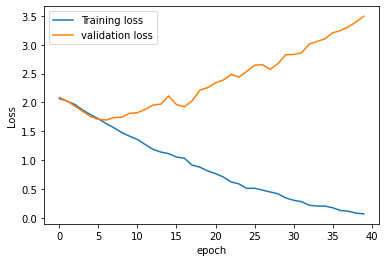

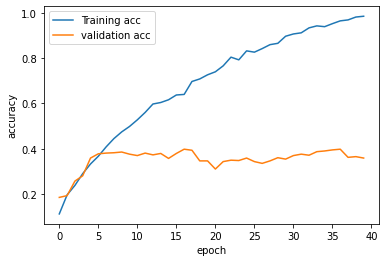

In [37]:
plt.plot(np.array(train_loss_values), label='Training loss')
plt.plot(np.array(validation_loss_values), label='validation loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(np.array(train_acc_list), label='Training acc')
plt.plot(np.array(validation_acc_list), label='validation acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [38]:
pred_list = []
test_label = []

with torch.no_grad():
  net.eval()
  for batch_id, (vector, label) in enumerate(tqdm_notebook(test_dataloader)):
    vector = vector.to(device)
    label = label.long().to(device)
    test_label.extend(label)
    out = net(vector)
    _, pred_value = torch.max(out, 1)
    pred_list.extend(pred_value.cpu().numpy())

pred_list = [a.squeeze().tolist() for a in pred_list]
test_label = [a.squeeze().tolist() for a in test_label]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [39]:
target_name = encoder.classes_
print(classification_report(test_label, pred_list, target_names=target_name, zero_division = 0))

                     precision    recall  f1-score   support

       Bruteforcing       0.09      0.12      0.11        42
    Data_structures       0.36      0.44      0.39        94
Dynamic_programming       0.27      0.27      0.27        91
       Graph_theory       0.44      0.42      0.43        92
             Greedy       0.16      0.12      0.14        42
     Implementation       0.32      0.35      0.34        88
        Mathematics       0.40      0.36      0.38       118
             String       0.39      0.26      0.31        42

           accuracy                           0.33       609
          macro avg       0.30      0.29      0.30       609
       weighted avg       0.33      0.33      0.33       609



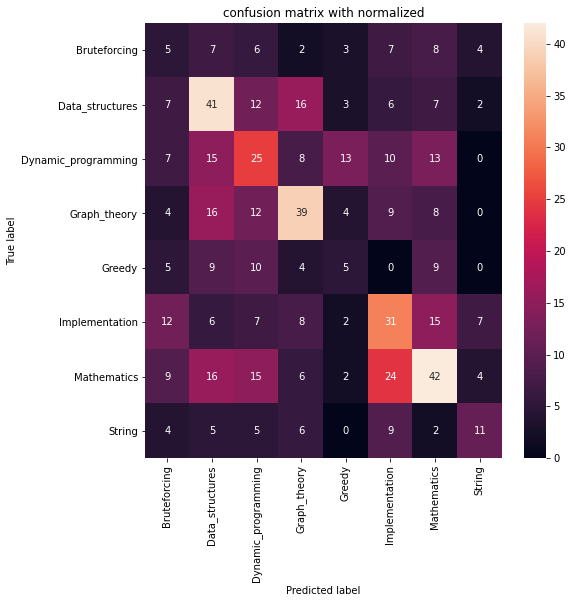

In [40]:
cm = confusion_matrix(test_label, pred_list)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, target_name, target_name)
plt.figure(figsize=(8, 8))
plt.title('confusion matrix with normalized')
sn.heatmap(df_cm, annot = True)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()